In [1]:
import multiprocess as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc

In [12]:
def read_data():
    basedir = './prepped_data/'
    
    main_data_df = pd.read_csv(basedir + 'main_data_ver_2.5.csv')
    print(1)
    coor_df = pd.read_csv(basedir + 'coor_data_ver_1.csv')
    print(2)
    land_prices_df = pd.read_csv(basedir + 'land_prices_ver_1.csv')
    print(3)
    land_specs_df = pd.read_csv(basedir + 'land_specs_ver_2.csv')
    print(4)
    bdinfo_df = pd.read_csv(basedir + 'bdinfo_ver_2.csv')
    
    return main_data_df, coor_df, land_prices_df, land_specs_df, bdinfo_df

In [13]:
%%time
main_data_df, coor_df, land_prices_df, land_specs_df, bdinfo_df = read_data()

1
2
3
4
Wall time: 10.9 s


In [14]:
main_data_df.head()

,전월세매매구분,전용면적(㎡),계약일,금액(만원),월세(만원),층,건축년도,가격/면적,년,월,target_log_transformed,target/area_log_transformed,건물종류,지번주소,대장구분명,도로명주소
0,매매,77.75,8,57000,0,2,1988,733.118971,2013,9,10.950807,6.597308,아파트,서울특별시 강남구 개포동 655-2,일반,서울특별시 강남구 언주로 103-0
1,매매,77.75,16,57000,0,2,1988,733.118971,2013,12,10.950807,6.597308,아파트,서울특별시 강남구 개포동 655-2,일반,서울특별시 강남구 언주로 103-0
2,매매,67.28,11,55000,0,5,1987,817.479191,2013,2,10.915088,6.706225,아파트,서울특별시 강남구 개포동 658-1,일반,서울특별시 강남구 언주로 3-0
3,매매,67.28,22,58250,0,4,1987,865.784780,2013,2,10.972499,6.763636,아파트,서울특별시 강남구 개포동 658-1,일반,서울특별시 강남구 언주로 3-0
4,매매,67.28,10,60000,0,5,1987,891.795482,2013,5,11.002100,6.793237,아파트,서울특별시 강남구 개포동 658-1,일반,서울특별시 강남구 언주로 3-0


In [15]:
land_specs_df.head()

,지번주소,대장구분명,년,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,공시지가
0,서울특별시 강남구 개포동 1163-4,일반,2013.0,대,336.1,제3종일반주거지역,지정되지않음,상업나지,평지,세로장방,광대세각,6290000.0
1,서울특별시 강남구 개포동 1163-4,일반,2014.0,대,336.1,제3종일반주거지역,지정되지않음,상업기타,평지,세로장방,광대세각,6480000.0
2,서울특별시 강남구 개포동 1163-4,일반,2015.0,대,336.1,제3종일반주거지역,지정되지않음,상업기타,평지,세로장방,광대세각,6870000.0
3,서울특별시 강남구 개포동 1163-4,일반,2016.0,대,336.1,제3종일반주거지역,지정되지않음,상업기타,평지,세로장방,광대세각,7125000.0
4,서울특별시 강남구 개포동 1163-4,일반,2017.0,대,336.1,제3종일반주거지역,지정되지않음,상업기타,평지,세로장방,광대세각,7485000.0


In [16]:
merge1_df = main_data_df.merge(land_specs_df, on=['지번주소', '년', '대장구분명'])
merge1_df.shape

(3174384, 25)

In [17]:
merge1_df.head()

,전월세매매구분,전용면적(㎡),계약일,금액(만원),월세(만원),층,건축년도,가격/면적,년,월,target_log_transformed,target/area_log_transformed,건물종류,지번주소,대장구분명,도로명주소,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,공시지가
0,매매,77.75,8,57000,0,2,1988,733.118971,2013,9,10.950807,6.597308,아파트,서울특별시 강남구 개포동 655-2,일반,서울특별시 강남구 언주로 103-0,대,1168.3,제3종일반주거지역,지정되지않음,아파트,평지,세로장방,광대세각,9210000.0
1,매매,77.75,16,57000,0,2,1988,733.118971,2013,12,10.950807,6.597308,아파트,서울특별시 강남구 개포동 655-2,일반,서울특별시 강남구 언주로 103-0,대,1168.3,제3종일반주거지역,지정되지않음,아파트,평지,세로장방,광대세각,9210000.0
2,전세,77.75,11,35000,0,4,1988,450.160772,2013,1,10.463103,6.109605,아파트,서울특별시 강남구 개포동 655-2,일반,서울특별시 강남구 언주로 103-0,대,1168.3,제3종일반주거지역,지정되지않음,아파트,평지,세로장방,광대세각,9210000.0
3,전세,77.75,4,32000,0,9,1988,411.575563,2013,3,10.373491,6.019993,아파트,서울특별시 강남구 개포동 655-2,일반,서울특별시 강남구 언주로 103-0,대,1168.3,제3종일반주거지역,지정되지않음,아파트,평지,세로장방,광대세각,9210000.0
4,전세,77.75,14,37000,0,1,1988,475.884244,2013,9,10.518673,6.165175,아파트,서울특별시 강남구 개포동 655-2,일반,서울특별시 강남구 언주로 103-0,대,1168.3,제3종일반주거지역,지정되지않음,아파트,평지,세로장방,광대세각,9210000.0


In [18]:
merge1_df = merge1_df[(merge1_df['전월세매매구분'] == '매매')|(merge1_df['전월세매매구분'] == '전세')]
print(merge1_df.shape)
merge1_df.head()

(2473476, 25)


,전월세매매구분,전용면적(㎡),계약일,금액(만원),월세(만원),층,건축년도,가격/면적,년,월,target_log_transformed,target/area_log_transformed,건물종류,지번주소,대장구분명,도로명주소,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,공시지가
0,매매,77.75,8,57000,0,2,1988,733.118971,2013,9,10.950807,6.597308,아파트,서울특별시 강남구 개포동 655-2,일반,서울특별시 강남구 언주로 103-0,대,1168.3,제3종일반주거지역,지정되지않음,아파트,평지,세로장방,광대세각,9210000.0
1,매매,77.75,16,57000,0,2,1988,733.118971,2013,12,10.950807,6.597308,아파트,서울특별시 강남구 개포동 655-2,일반,서울특별시 강남구 언주로 103-0,대,1168.3,제3종일반주거지역,지정되지않음,아파트,평지,세로장방,광대세각,9210000.0
2,전세,77.75,11,35000,0,4,1988,450.160772,2013,1,10.463103,6.109605,아파트,서울특별시 강남구 개포동 655-2,일반,서울특별시 강남구 언주로 103-0,대,1168.3,제3종일반주거지역,지정되지않음,아파트,평지,세로장방,광대세각,9210000.0
3,전세,77.75,4,32000,0,9,1988,411.575563,2013,3,10.373491,6.019993,아파트,서울특별시 강남구 개포동 655-2,일반,서울특별시 강남구 언주로 103-0,대,1168.3,제3종일반주거지역,지정되지않음,아파트,평지,세로장방,광대세각,9210000.0
4,전세,77.75,14,37000,0,1,1988,475.884244,2013,9,10.518673,6.165175,아파트,서울특별시 강남구 개포동 655-2,일반,서울특별시 강남구 언주로 103-0,대,1168.3,제3종일반주거지역,지정되지않음,아파트,평지,세로장방,광대세각,9210000.0


In [20]:
merge1_df['건물나이'] = merge1_df['년'] - merge1_df['건축년도']

In [21]:
merge1_df.drop(columns=['건축년도'], inplace=True)

In [23]:
merge1_df['year_linear'] = (merge1_df['년'] - merge1_df['년'].min()) + ((merge1_df['월']-1)/12)

In [24]:
def month_circular_sine_func(x):
    return math.sin(2*math.pi*((x-1)/12))

def month_circular_cosine_func(x):
    return math.cos(2*math.pi*((x-1)/12))

In [25]:
merge1_df['month_sin'] = merge1_df['월'].apply(month_circular_sine_func)
merge1_df['month_cos'] = merge1_df['월'].apply(month_circular_cosine_func)

In [26]:
merge1_df.drop(columns=['월', '계약일'], inplace=True)

In [27]:
merge1_df = merge1_df[merge1_df['건물나이'] >= 0]

In [28]:
landnum_df = coor_df[['지번주소', 'x좌표', 'y좌표']].dropna()
roadname_df = coor_df[['도로명주소', 'x좌표', 'y좌표']].drop(landnum_df.index).reset_index(drop=True)
landnum_df.reset_index(drop=True, inplace=True)

In [29]:
merge2_df = merge1_df.merge(roadname_df, on=['도로명주소'], how='left')

In [30]:
merge3_df = merge2_df.merge(landnum_df, on=['지번주소'], how='left')

In [31]:
merge3_df['x좌표'] = merge3_df['x좌표_x'].fillna(merge3_df['x좌표_y'])
merge3_df['y좌표'] = merge3_df['y좌표_x'].fillna(merge3_df['y좌표_y'])
merge3_df.dropna(subset=['x좌표', 'y좌표'], inplace=True)

In [32]:
merge3_df.drop(columns=['x좌표_x', 'y좌표_x', 'x좌표_y', 'y좌표_y'], inplace=True)

In [33]:
merge3_df['공시지가'] = merge3_df['공시지가'] / 10000
merge3_df.rename(columns={'공시지가':'공시지가(만원)'}, inplace=True)

In [34]:
x_y_min_max = pd.read_csv('./feature_maps/x_y_min_max.csv')

In [35]:
merge3_df['x_norm'] = (merge3_df['x좌표'] - x_y_min_max['x_min'][0]) - ((x_y_min_max['x_max'][0] - x_y_min_max['x_min'][0])/2)
merge3_df['y_norm'] = (merge3_df['y좌표'] - x_y_min_max['y_min'][0]) - ((x_y_min_max['y_max'][0] - x_y_min_max['y_min'][0])/2)

In [36]:
merge3_df.drop(columns=['x좌표', 'y좌표'], inplace=True)
merge3_df['x_2nd'] = merge3_df['x_norm'] ** 2
merge3_df['y_2nd'] = merge3_df['y_norm'] ** 2
merge3_df['x*y'] = merge3_df['x_norm']*merge3_df['y_norm']
merge3_df['x_sin'] = np.sin(merge3_df['x_norm'])
merge3_df['y_sin'] = np.sin(merge3_df['y_norm'])
merge3_df['x_cos'] = np.cos(merge3_df['x_norm'])
merge3_df['y_cos'] = np.cos(merge3_df['y_norm'])

In [37]:
merge3_df.drop(columns=['월세(만원)'], inplace=True)

In [38]:
bdinfo_df.head()

,지번주소,대장_구분,구조,주_용도,지붕,기타용도_주택종류,첫기타용도,둘째기타용도,셋째기타용도,기타용도갯수,첫째기타구조,둘째기타구조,셋째기타구조,기타지붕종류수,첫째기타지붕,둘째기타지붕,셋째기타지붕,옥내기계식주차장있음,옥외기계식주차장있음,비상용승강기있음,부속건물있음,외필지있음,연면적(㎡)_mean,지상_층_수_mean,지하_층_수_mean,승용_승강기_수_mean,세대가구호_수_mean,총주차대수_mean,총주차장면적_mean,집당연면적,집당층수,집당주차대수,집당주차면적,사용승인_년,기준년도
0,서울특별시 강남구 개포동 1163-4,집합,철근콘크리트구조,공동주택,철근콘크리트,도시형unknown,도시형unknown,종교시설,셋째용도없음,2개,벽식조,일반철골조,셋째기타구조없음,1개,철근콘크리트,둘째지붕없음,셋째지붕없음,0.0,0.0,0.0,0.0,0.0,1102.75,7.0,1.0,1.0,20.0,9.0,138.0,55.1375,0.35,0.45,6.9,2013.0,2013.0
1,서울특별시 강남구 개포동 1163-4,집합,철근콘크리트구조,공동주택,철근콘크리트,도시형unknown,도시형unknown,종교시설,셋째용도없음,2개,벽식조,일반철골조,셋째기타구조없음,1개,철근콘크리트,둘째지붕없음,셋째지붕없음,0.0,0.0,0.0,0.0,0.0,1102.75,7.0,1.0,1.0,20.0,9.0,138.0,55.1375,0.35,0.45,6.9,2013.0,2014.0
2,서울특별시 강남구 개포동 1163-4,집합,철근콘크리트구조,공동주택,철근콘크리트,도시형unknown,도시형unknown,종교시설,셋째용도없음,2개,벽식조,일반철골조,셋째기타구조없음,1개,철근콘크리트,둘째지붕없음,셋째지붕없음,0.0,0.0,0.0,0.0,0.0,1102.75,7.0,1.0,1.0,20.0,9.0,138.0,55.1375,0.35,0.45,6.9,2013.0,2015.0
3,서울특별시 강남구 개포동 1163-4,집합,철근콘크리트구조,공동주택,철근콘크리트,도시형unknown,도시형unknown,종교시설,셋째용도없음,2개,벽식조,일반철골조,셋째기타구조없음,1개,철근콘크리트,둘째지붕없음,셋째지붕없음,0.0,0.0,0.0,0.0,0.0,1102.75,7.0,1.0,1.0,20.0,9.0,138.0,55.1375,0.35,0.45,6.9,2013.0,2016.0
4,서울특별시 강남구 개포동 1163-4,집합,철근콘크리트구조,공동주택,철근콘크리트,도시형unknown,도시형unknown,종교시설,셋째용도없음,2개,벽식조,일반철골조,셋째기타구조없음,1개,철근콘크리트,둘째지붕없음,셋째지붕없음,0.0,0.0,0.0,0.0,0.0,1102.75,7.0,1.0,1.0,20.0,9.0,138.0,55.1375,0.35,0.45,6.9,2013.0,2017.0


In [39]:
bdinfo_df.rename(columns={'기준년도':'년'}, inplace=True)

In [61]:
merge4_df = merge3_df.merge(bdinfo_df, on=['지번주소', '년'])

In [62]:
merge4_df.drop(columns=['지번주소', '도로명주소', '사용승인_년'], inplace=True)
merge4_df.head()

,전월세매매구분,전용면적(㎡),금액(만원),층,가격/면적,년,target_log_transformed,target/area_log_transformed,건물종류,대장구분명,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,공시지가(만원),건물나이,year_linear,month_sin,month_cos,x_norm,y_norm,x_2nd,y_2nd,x*y,x_sin,y_sin,x_cos,y_cos,대장_구분,구조,주_용도,지붕,기타용도_주택종류,첫기타용도,둘째기타용도,셋째기타용도,기타용도갯수,첫째기타구조,둘째기타구조,셋째기타구조,기타지붕종류수,첫째기타지붕,둘째기타지붕,셋째기타지붕,옥내기계식주차장있음,옥외기계식주차장있음,비상용승강기있음,부속건물있음,외필지있음,연면적(㎡)_mean,지상_층_수_mean,지하_층_수_mean,승용_승강기_수_mean,세대가구호_수_mean,총주차대수_mean,총주차장면적_mean,집당연면적,집당층수,집당주차대수,집당주차면적
0,매매,77.75,57000,2,733.118971,2013,10.950807,6.597308,아파트,일반,대,1168.3,제3종일반주거지역,지정되지않음,아파트,평지,세로장방,광대세각,921.0,25,0.666667,-0.866025,-0.500000,5540.076032,-9058.615505,3.069244e+07,8.205851e+07,-5.018542e+07,-0.992492,0.986102,-0.122306,-0.166138,집합,철근콘크리트구조,공동주택,철근콘크리트,주택unknown,주택unknown,둘째용도없음,셋째용도없음,1개,철근콘크리트조,둘째기타구조없음,셋째기타구조없음,1개,슬라브,둘째지붕없음,셋째지붕없음,0.0,0.0,0.0,0.0,1.0,5321.05,9.0,1.0,0.0,54.0,0.0,0.0,98.537963,0.166667,0.0,0.0
1,매매,77.75,57000,2,733.118971,2013,10.950807,6.597308,아파트,일반,대,1168.3,제3종일반주거지역,지정되지않음,아파트,평지,세로장방,광대세각,921.0,25,0.916667,-0.500000,0.866025,5540.076032,-9058.615505,3.069244e+07,8.205851e+07,-5.018542e+07,-0.992492,0.986102,-0.122306,-0.166138,집합,철근콘크리트구조,공동주택,철근콘크리트,주택unknown,주택unknown,둘째용도없음,셋째용도없음,1개,철근콘크리트조,둘째기타구조없음,셋째기타구조없음,1개,슬라브,둘째지붕없음,셋째지붕없음,0.0,0.0,0.0,0.0,1.0,5321.05,9.0,1.0,0.0,54.0,0.0,0.0,98.537963,0.166667,0.0,0.0
2,전세,77.75,35000,4,450.160772,2013,10.463103,6.109605,아파트,일반,대,1168.3,제3종일반주거지역,지정되지않음,아파트,평지,세로장방,광대세각,921.0,25,0.000000,0.000000,1.000000,5540.076032,-9058.615505,3.069244e+07,8.205851e+07,-5.018542e+07,-0.992492,0.986102,-0.122306,-0.166138,집합,철근콘크리트구조,공동주택,철근콘크리트,주택unknown,주택unknown,둘째용도없음,셋째용도없음,1개,철근콘크리트조,둘째기타구조없음,셋째기타구조없음,1개,슬라브,둘째지붕없음,셋째지붕없음,0.0,0.0,0.0,0.0,1.0,5321.05,9.0,1.0,0.0,54.0,0.0,0.0,98.537963,0.166667,0.0,0.0
3,전세,77.75,32000,9,411.575563,2013,10.373491,6.019993,아파트,일반,대,1168.3,제3종일반주거지역,지정되지않음,아파트,평지,세로장방,광대세각,921.0,25,0.166667,0.866025,0.500000,5540.076032,-9058.615505,3.069244e+07,8.205851e+07,-5.018542e+07,-0.992492,0.986102,-0.122306,-0.166138,집합,철근콘크리트구조,공동주택,철근콘크리트,주택unknown,주택unknown,둘째용도없음,셋째용도없음,1개,철근콘크리트조,둘째기타구조없음,셋째기타구조없음,1개,슬라브,둘째지붕없음,셋째지붕없음,0.0,0.0,0.0,0.0,1.0,5321.05,9.0,1.0,0.0,54.0,0.0,0.0,98.537963,0.166667,0.0,0.0
4,전세,77.75,37000,1,475.884244,2013,10.518673,6.165175,아파트,일반,대,1168.3,제3종일반주거지역,지정되지않음,아파트,평지,세로장방,광대세각,921.0,25,0.666667,-0.866025,-0.500000,5540.076032,-9058.615505,3.069244e+07,8.205851e+07,-5.018542e+07,-0.992492,0.986102,-0.122306,-0.166138,집합,철근콘크리트구조,공동주택,철근콘크리트,주택unknown,주택unknown,둘째용도없음,셋째용도없음,1개,철근콘크리트조,둘째기타구조없음,셋째기타구조없음,1개,슬라브,둘째지붕없음,셋째지붕없음,0.0,0.0,0.0,0.0,1.0,5321.05,9.0,1.0,0.0,54.0,0.0,0.0,98.537963,0.166667,0.0,0.0


In [63]:
merge4_df.drop(columns=['대장구분명'], inplace=True)

In [64]:
cat_cols = ['전월세매매구분', '건물종류', '지목명', '용도지역명1', '용도지역명2', '토지이동상황', '지형높이', '지형형상', '도로접면',
            '대장_구분', '구조', '주_용도', '지붕', '기타용도_주택종류', '첫기타용도', '둘째기타용도', '셋째기타용도',
            '기타용도갯수', '첫째기타구조', '둘째기타구조', '셋째기타구조', '기타지붕종류수', '첫째기타지붕', '둘째기타지붕',
            '셋째기타지붕'
           ]

In [65]:
for col in cat_cols:
    try:
        col_map_df = pd.DataFrame({'cat':merge4_df[col].unique(), 'map':[i for i in range(len(merge4_df[col].unique()))]})
    except:
        print(col)
        raise ValueError('myerror')
    col_map_df.to_csv('./feature_maps/{}_map_for_training_data_ver_8.csv'.format(col), index=False)
    col_map = {}
    for i in range(col_map_df.shape[0]):
        col_map[col_map_df['cat'][i]] = col_map_df['map'][i]
    merge4_df[col+'_mapped'] = merge4_df[col].map(col_map)

In [66]:
merge4_df.drop(columns=cat_cols, inplace=True)
merge4_df.head()

,전용면적(㎡),금액(만원),층,가격/면적,년,target_log_transformed,target/area_log_transformed,토지면적,공시지가(만원),건물나이,year_linear,month_sin,month_cos,x_norm,y_norm,x_2nd,y_2nd,x*y,x_sin,y_sin,x_cos,y_cos,옥내기계식주차장있음,옥외기계식주차장있음,비상용승강기있음,부속건물있음,외필지있음,연면적(㎡)_mean,지상_층_수_mean,지하_층_수_mean,승용_승강기_수_mean,세대가구호_수_mean,총주차대수_mean,총주차장면적_mean,집당연면적,집당층수,집당주차대수,집당주차면적,전월세매매구분_mapped,건물종류_mapped,지목명_mapped,용도지역명1_mapped,용도지역명2_mapped,토지이동상황_mapped,지형높이_mapped,지형형상_mapped,도로접면_mapped,대장_구분_mapped,구조_mapped,주_용도_mapped,지붕_mapped,기타용도_주택종류_mapped,첫기타용도_mapped,둘째기타용도_mapped,셋째기타용도_mapped,기타용도갯수_mapped,첫째기타구조_mapped,둘째기타구조_mapped,셋째기타구조_mapped,기타지붕종류수_mapped,첫째기타지붕_mapped,둘째기타지붕_mapped,셋째기타지붕_mapped
0,77.75,57000,2,733.118971,2013,10.950807,6.597308,1168.3,921.0,25,0.666667,-0.866025,-0.500000,5540.076032,-9058.615505,3.069244e+07,8.205851e+07,-5.018542e+07,-0.992492,0.986102,-0.122306,-0.166138,0.0,0.0,0.0,0.0,1.0,5321.05,9.0,1.0,0.0,54.0,0.0,0.0,98.537963,0.166667,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,77.75,57000,2,733.118971,2013,10.950807,6.597308,1168.3,921.0,25,0.916667,-0.500000,0.866025,5540.076032,-9058.615505,3.069244e+07,8.205851e+07,-5.018542e+07,-0.992492,0.986102,-0.122306,-0.166138,0.0,0.0,0.0,0.0,1.0,5321.05,9.0,1.0,0.0,54.0,0.0,0.0,98.537963,0.166667,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,77.75,35000,4,450.160772,2013,10.463103,6.109605,1168.3,921.0,25,0.000000,0.000000,1.000000,5540.076032,-9058.615505,3.069244e+07,8.205851e+07,-5.018542e+07,-0.992492,0.986102,-0.122306,-0.166138,0.0,0.0,0.0,0.0,1.0,5321.05,9.0,1.0,0.0,54.0,0.0,0.0,98.537963,0.166667,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,77.75,32000,9,411.575563,2013,10.373491,6.019993,1168.3,921.0,25,0.166667,0.866025,0.500000,5540.076032,-9058.615505,3.069244e+07,8.205851e+07,-5.018542e+07,-0.992492,0.986102,-0.122306,-0.166138,0.0,0.0,0.0,0.0,1.0,5321.05,9.0,1.0,0.0,54.0,0.0,0.0,98.537963,0.166667,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,77.75,37000,1,475.884244,2013,10.518673,6.165175,1168.3,921.0,25,0.666667,-0.866025,-0.500000,5540.076032,-9058.615505,3.069244e+07,8.205851e+07,-5.018542e+07,-0.992492,0.986102,-0.122306,-0.166138,0.0,0.0,0.0,0.0,1.0,5321.05,9.0,1.0,0.0,54.0,0.0,0.0,98.537963,0.166667,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [67]:
merge4_df.drop(columns=['년'], inplace=True)

In [68]:
numeric_cols = ['전용면적(㎡)', '층', '토지면적', '공시지가(만원)', '건물나이', '연면적(㎡)_mean', '지상_층_수_mean',
                '지하_층_수_mean', '승용_승강기_수_mean', '세대가구호_수_mean', '총주차대수_mean', '총주차장면적_mean',
                '집당연면적', '집당층수', '집당주차대수', '집당주차면적'
               ]

<AxesSubplot:>

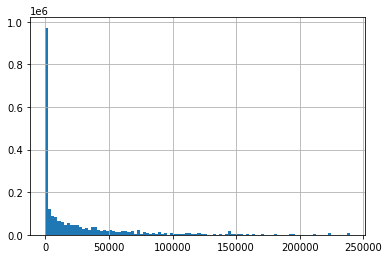

In [69]:
merge4_df['토지면적'].hist(bins=100)

In [75]:
from sklearn.preprocessing import RobustScaler, quantile_transform

In [85]:
for col in numeric_cols:
    merge4_df[col+'_quantile_transformed'] = quantile_transform(merge4_df[[col]], output_distribution='normal')

In [88]:
merge4_df.drop(columns=numeric_cols, inplace=True)

In [89]:
merge4_df.head()

,금액(만원),가격/면적,target_log_transformed,target/area_log_transformed,year_linear,month_sin,month_cos,x_norm,y_norm,x_2nd,y_2nd,x*y,x_sin,y_sin,x_cos,y_cos,옥내기계식주차장있음,옥외기계식주차장있음,비상용승강기있음,부속건물있음,외필지있음,전월세매매구분_mapped,건물종류_mapped,지목명_mapped,용도지역명1_mapped,용도지역명2_mapped,토지이동상황_mapped,지형높이_mapped,지형형상_mapped,도로접면_mapped,대장_구분_mapped,구조_mapped,주_용도_mapped,지붕_mapped,기타용도_주택종류_mapped,첫기타용도_mapped,둘째기타용도_mapped,셋째기타용도_mapped,기타용도갯수_mapped,첫째기타구조_mapped,둘째기타구조_mapped,셋째기타구조_mapped,기타지붕종류수_mapped,첫째기타지붕_mapped,둘째기타지붕_mapped,셋째기타지붕_mapped,전용면적(㎡)_quantile_transformed,층_quantile_transformed,토지면적_quantile_transformed,공시지가(만원)_quantile_transformed,건물나이_quantile_transformed,연면적(㎡)_mean_quantile_transformed,지상_층_수_mean_quantile_transformed,지하_층_수_mean_quantile_transformed,승용_승강기_수_mean_quantile_transformed,세대가구호_수_mean_quantile_transformed,총주차대수_mean_quantile_transformed,총주차장면적_mean_quantile_transformed,집당연면적_quantile_transformed,집당층수_quantile_transformed,집당주차대수_quantile_transformed,집당주차면적_quantile_transformed
0,57000,733.118971,10.950807,6.597308,0.666667,-0.866025,-0.500000,5540.076032,-9058.615505,3.069244e+07,8.205851e+07,-5.018542e+07,-0.992492,0.986102,-0.122306,-0.166138,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.36032,-0.997920,-0.286357,1.361821,0.916587,-0.163249,-0.284828,0.324254,-5.199338,-0.14478,-5.199338,-5.199338,0.186902,-0.483658,-5.199338,-5.199338
1,57000,733.118971,10.950807,6.597308,0.916667,-0.500000,0.866025,5540.076032,-9058.615505,3.069244e+07,8.205851e+07,-5.018542e+07,-0.992492,0.986102,-0.122306,-0.166138,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.36032,-0.997920,-0.286357,1.361821,0.916587,-0.163249,-0.284828,0.324254,-5.199338,-0.14478,-5.199338,-5.199338,0.186902,-0.483658,-5.199338,-5.199338
2,35000,450.160772,10.463103,6.109605,0.000000,0.000000,1.000000,5540.076032,-9058.615505,3.069244e+07,8.205851e+07,-5.018542e+07,-0.992492,0.986102,-0.122306,-0.166138,0.0,0.0,0.0,0.0,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.36032,-0.223916,-0.286357,1.361821,0.916587,-0.163249,-0.284828,0.324254,-5.199338,-0.14478,-5.199338,-5.199338,0.186902,-0.483658,-5.199338,-5.199338
3,32000,411.575563,10.373491,6.019993,0.166667,0.866025,0.500000,5540.076032,-9058.615505,3.069244e+07,8.205851e+07,-5.018542e+07,-0.992492,0.986102,-0.122306,-0.166138,0.0,0.0,0.0,0.0,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.36032,0.555462,-0.286357,1.361821,0.916587,-0.163249,-0.284828,0.324254,-5.199338,-0.14478,-5.199338,-5.199338,0.186902,-0.483658,-5.199338,-5.199338
4,37000,475.884244,10.518673,6.165175,0.666667,-0.866025,-0.500000,5540.076032,-9058.615505,3.069244e+07,8.205851e+07,-5.018542e+07,-0.992492,0.986102,-0.122306,-0.166138,0.0,0.0,0.0,0.0,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.36032,-1.620592,-0.286357,1.361821,0.916587,-0.163249,-0.284828,0.324254,-5.199338,-0.14478,-5.199338,-5.199338,0.186902,-0.483658,-5.199338,-5.199338


In [90]:
%%time
merge4_df.to_csv('./prepped_data/training_data_ver_8(bdinfo_no_land).csv', index=False)

Wall time: 1min 43s


전용면적(㎡)


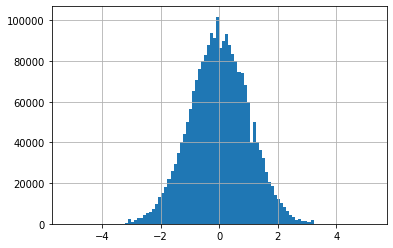

층


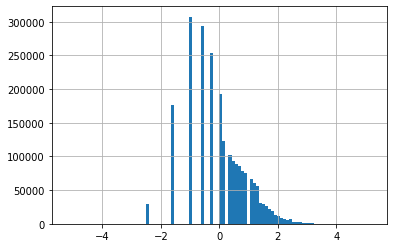

토지면적


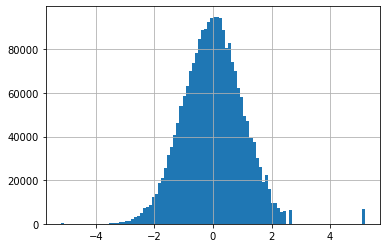

공시지가(만원)


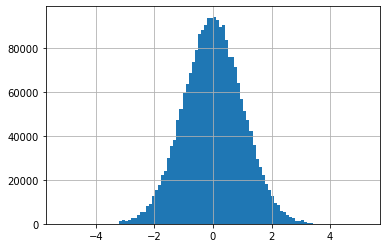

건물나이


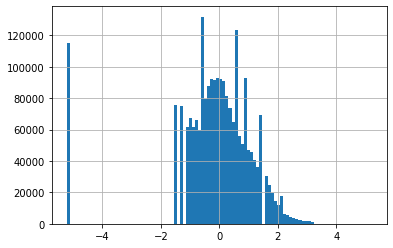

연면적(㎡)_mean


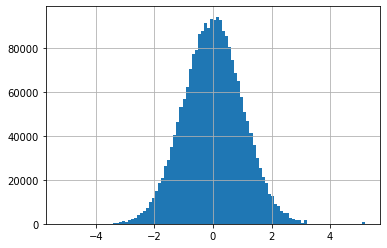

지상_층_수_mean


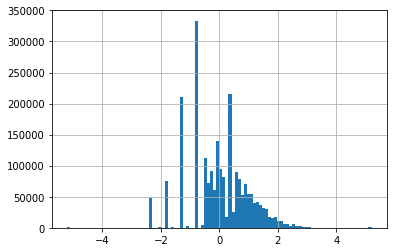

지하_층_수_mean


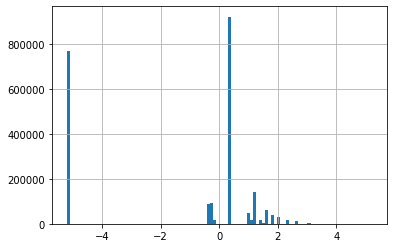

승용_승강기_수_mean


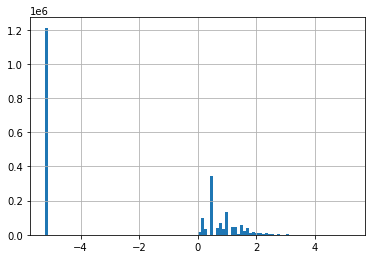

세대가구호_수_mean


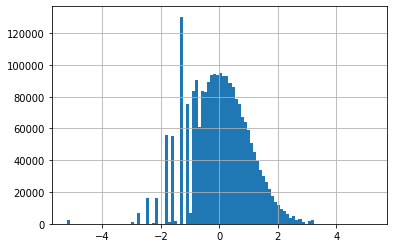

총주차대수_mean


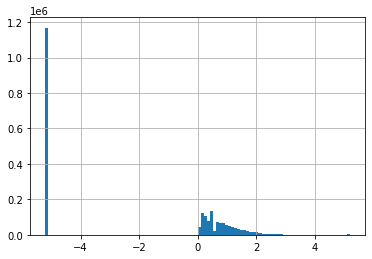

총주차장면적_mean


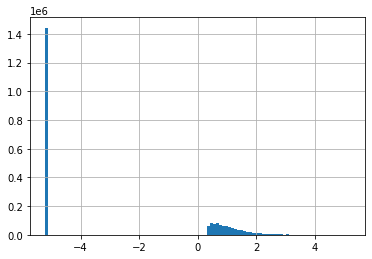

집당연면적


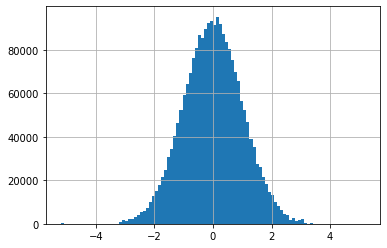

집당층수


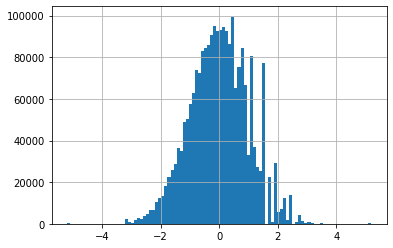

집당주차대수


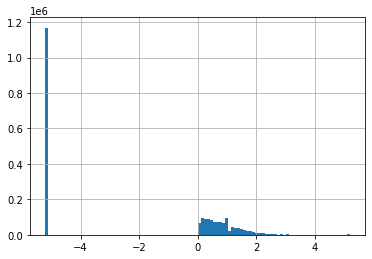

집당주차면적


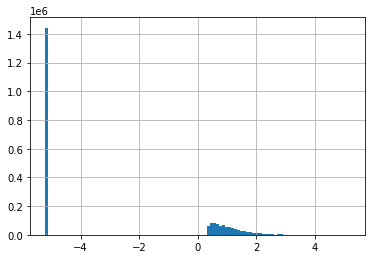

<Figure size 432x288 with 0 Axes>

In [91]:
for col in numeric_cols:
    print(col)
    merge4_df[col+'_quantile_transformed'].hist(bins=100)
    plt.show()
    plt.clf()